Buscando el mejor Learning Rate para: Scale Pos Weight...
Buscando el mejor Learning Rate para: SMOTE + Tomek...
Buscando el mejor Learning Rate para: SMOTE + ENN...
Buscando el mejor Learning Rate para: NearMiss...
Buscando el mejor Learning Rate para: ADASYN...


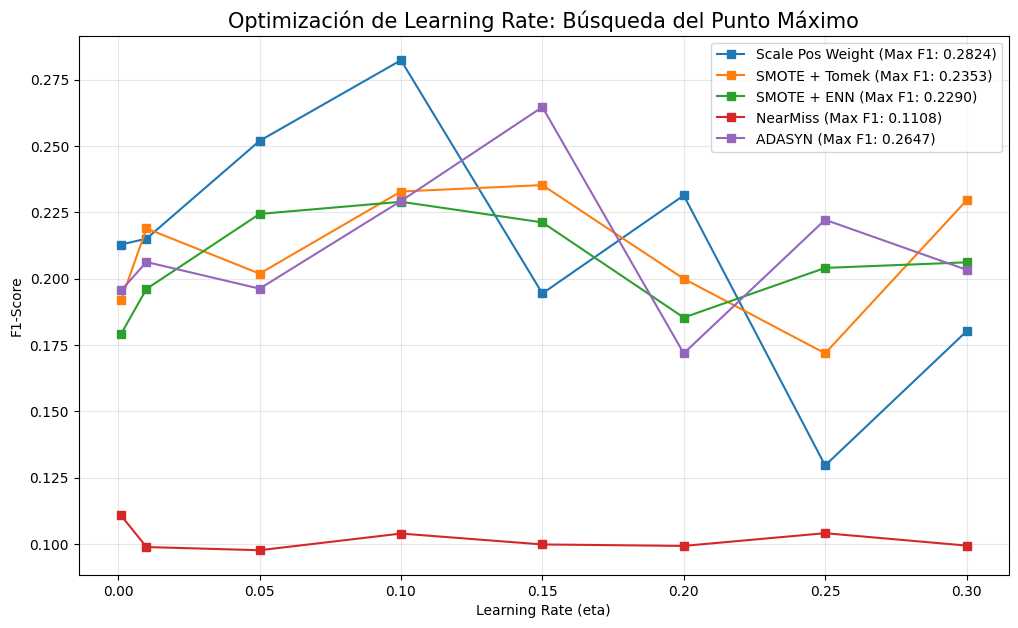


TÉCNICA              | N_EST  | BEST LR  | MAX F1  
------------------------------------------------------------
Scale Pos Weight     | 125    | 0.1      | 0.2824
SMOTE + Tomek        | 256    | 0.15     | 0.2353
SMOTE + ENN          | 171    | 0.1      | 0.2290
NearMiss             | 271    | 0.001    | 0.1108
ADASYN               | 242    | 0.15     | 0.2647


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación de datos (Asegurando codificación)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)

X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

# 2. Configuración con tus resultados previos de n_estimators
config_ganadora = {
    'Scale Pos Weight': (None, 125),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171),
    'NearMiss': (NearMiss(), 271),
    'ADASYN': (ADASYN(random_state=42), 242)
}

lr_range = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
final_lr_results = [] # Aquí guardaremos los máximos

plt.figure(figsize=(12, 7))

for nombre, (sampler, n_optimo) in config_ganadora.items():
    lrs_f1 = []
    
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1
        
    print(f"Buscando el mejor Learning Rate para: {nombre}...")
    
    for lr in lr_range:
        model = XGBClassifier(
            n_estimators=n_optimo,
            learning_rate=lr,
            max_depth=5, 
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        lrs_f1.append(f1_score(y_test, y_pred))
    
    # --- Lógica para encontrar el máximo ---
    max_f1 = max(lrs_f1)
    best_lr = lr_range[lrs_f1.index(max_f1)]
    final_lr_results.append({
        'Técnica': nombre, 
        'n_estimators': n_optimo, 
        'Best LR': best_lr, 
        'Max F1': max_f1
    })
    
    plt.plot(lr_range, lrs_f1, marker='s', label=f"{nombre} (Max F1: {max_f1:.4f})")

plt.title('Optimización de Learning Rate: Búsqueda del Punto Máximo', fontsize=15)
plt.xlabel('Learning Rate (eta)')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Impresión de Resultados Finales
print("\n" + "="*60)
print(f"{'TÉCNICA':<20} | {'N_EST':<6} | {'BEST LR':<8} | {'MAX F1':<8}")
print("-"*60)
for r in final_lr_results:
    print(f"{r['Técnica']:<20} | {r['n_estimators']:<6} | {r['Best LR']:<8} | {r['Max F1']:.4f}")
print("="*60)